#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

#from bvcopula import SingleParamCopulaBase
from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel
from bvcopula import Mixed_GPInferenceModel, GridInterpolationVariationalStrategy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

animal = 'ST263'
day_name = 'Day1'
path = '/home/nina/VRData/Processing/pkls'

with open("{}/{}_{}_signals.pkl".format(path,animal,day_name),'rb') as f:
    signal_pkl = pkl.load(f)
with open("{}/{}_{}_behaviour.pkl".format(path,animal,day_name),'rb') as f:
    behaviour_pkl = pkl.load(f)
for s in ['ROIsN','trialStart','maxTrialNum','trials']:
    assert(np.allclose(signal_pkl[s],behaviour_pkl[s]))

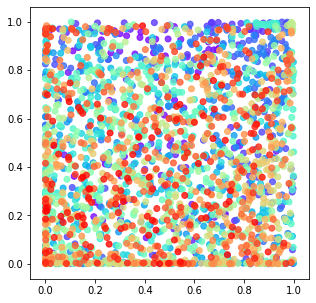

In [3]:
signals = signal_pkl['signals_transformed']
n1 = 13
n2 = 17
Y_all = np.array([signals[n1],signals[n2]]).T
X_all = np.array(behaviour_pkl['position'])#local_time

rule = (Y_all[:,0]>1e-4) & (Y_all[:,1]>1e-4)  \
        & (Y_all[:,0]<1.-1e-4) & (Y_all[:,1]<1.-1e-4)#\
        #& (X_all > 120.)#& (time>7*60)
 
X = np.reshape(X_all[rule],(-1,1))
X[X<0] = 160.+X[X<0]
X[X>160] = X[X>160]-160.
X = X/160.
Y = Y_all[rule]

NSamp = X.shape[0]
plt.figure(figsize=(5,5))
colors = cm.rainbow(np.linspace(0., 1., NSamp))
skip = 3
plt.scatter(*Y[::skip].T, color=colors[::skip], alpha=0.8)

# X = np.flip(X,axis=0).copy()
# Y = np.flip(Y,axis=0).copy()

In [4]:
#likelihoods = [ClaytonCopula_Likelihood(rotation='0°'),ClaytonCopula_Likelihood(rotation='180°'),GaussianCopula_Likelihood()]
likelihoods = [ClaytonCopula_Likelihood(rotation='0°'),
              ClaytonCopula_Likelihood(rotation='180°'),
                ClaytonCopula_Likelihood(rotation='90°'),
              ClaytonCopula_Likelihood(rotation='270°'),]

In [5]:
NSamp

6898

In [6]:
Y[Y!=Y]

array([], dtype=float64)

In [7]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [8]:
# define the model (optionally on GPU)
grid_size = 128#train_x.shape[0]
model = Mixed_GPInferenceModel(MixtureCopula_Likelihood(likelihoods), 2*len(likelihoods)-1, \
                               prior_rbf_length=0.2, grid_size=grid_size).cuda(device=0)

In [9]:
# train the model

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

#torch.autograd.set_detect_anomaly(True)

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.covar_module.raw_outputscale},
    {'params': model.variational_strategy.variational_distribution.variational_mean, 'lr': .1},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .01} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
#mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        
#         if i==0:
#             prior_mean = model.variational_strategy.variational_distribution.variational_mean.data
#             prior_mean[2][96:112] = 0.5*torch.ones_like(prior_mean[2][96:112])
#             #prior_mean[1] = 0.0*torch.ones_like(prior_mean[0])
#             model.variational_strategy.variational_distribution.variational_mean.data = prior_mean
            
        loss = -mll(output, train_y)  
        #log_lik, kl_div, log_prior = mllv(output, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            loss_scale = np.abs(loss.detach().cpu().numpy() - np.mean(losses))
            
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                mean_p/loss_scale, np.mean(means[-1]), 
                np.mean(np.abs(means[-100]-means[-1]))
            ))
            #print("{:.3}, {:.3}, {:.3}".format(log_lik, kl_div, log_prior))

            #print(np.std(losses[-100:]))
            if (0 < mean_p/loss_scale < 0.001):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step

        loss.backward()
        for n, par in model.named_parameters():
            grad = par.grad.data
            if torch.nonzero(grad!=grad).shape[0]!=0:
                print('NaN grad in {}'.format(n))
            nans+=torch.nonzero(grad!=grad).shape[0]
            if torch.any(grad.abs()==float('inf')):
                print("Grad inf... fixing...")
                grad = torch.clamp(grad,-1.,1.)
            grad[grad!=grad] = 0.0
            par.grad.data = grad
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        assert torch.all(covar_grad==covar_grad)
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.001
Iter 100/2000 - Loss: 0.083   lengthscale: [0.15674613 0.16758607 0.19504127 0.15555838 0.14178406 0.16093646
 0.20757969], dLoss: 0.0, mean f: -1.08, dmean: 1.25
Iter 200/2000 - Loss: 0.00814   lengthscale: [0.17739129 0.22477551 0.21908118 0.15857919 0.15707748 0.11092273
 0.20031236], dLoss: 0.707, mean f: -1.63, dmean: 0.688
Iter 300/2000 - Loss: -0.0108   lengthscale: [0.19638123 0.2643497  0.24394718 0.18229154 0.16494292 0.08711918
 0.19340536], dLoss: 0.191, mean f: -1.9, dmean: 0.358
Iter 400/2000 - Loss: -0.0168   lengthscale: [0.2134157  0.3108327  0.27304643 0.21219255 0.16477816 0.07792316
 0.19055276], dLoss: 0.0713, mean f: -2.05, dmean: 0.202
Iter 500/2000 - Loss: -0.0206   lengthscale: [0.23451558 0.37821352 0.3051052  0.2414325  0.16238865 0.07305593
 0.18785365], dLoss: 0.0364, mean f: -2.13, dmean: 0.132
Iter 600/2000 - Loss: -0.023   lengthscale: [0.2583673  0.4408393  0.34124118 0.27155903 0.157956   0.06978942
 0.18435661], 

(2000, 7, 128)


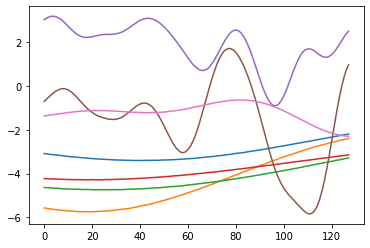

In [10]:
print(np.shape(means))
for i in range(2*len(likelihoods)-1):
    plt.plot(means[-1][i])
losses[losses!=losses] = 0

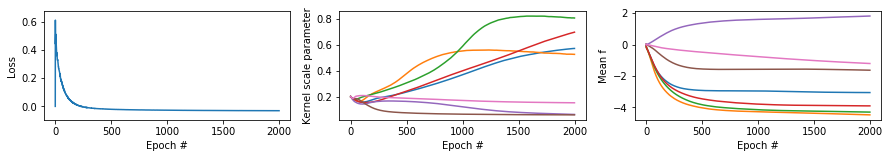

In [16]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
marg = (np.max(losses) - np.min(losses))*0.1
loss.set_ylim(np.min(losses)-marg,
              np.max(losses)+marg)
rbf=np.array(rbf).squeeze()
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x,axis=1) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [12]:
# define test set (optionally on GPU)
denser = 1 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

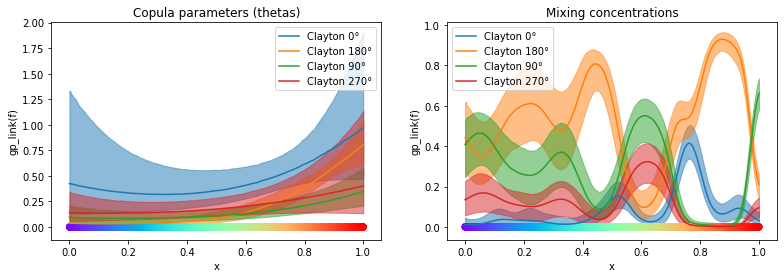

In [13]:
# visualize the result
fig, ax = plt.subplots(1,2,figsize=(13, 4))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function

thetas, mixes = gplink(output.mean)
lower, upper = output.confidence_region() #thetas & mix together
thetas_low, mixes_low = gplink(lower)
thetas_upp, mixes_upp = gplink(upper)

copulas = [lik.name for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]
 
for t,l,u,c,r in zip(thetas,thetas_low,thetas_upp,copulas,rotations):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0].plot(testX, F_mean, label = '{} {}'.format(c,r))
    ax[0].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)
    
ax[0].scatter(np.linspace(0., 1., NSamp),np.zeros(NSamp),color=colors)
ax[0].set_xlabel('x')
ax[0].set_ylabel('gp_link(f)')
ax[0].set_title('Copula parameters (thetas)')
ax[0].legend()

_, sampled = gplink(output.rsample(torch.Size([100])))

for i, (t,c,r) in enumerate(zip(mixes[:],copulas,rotations)):
    F_mean = t.detach().cpu().numpy()
    line, = ax[1].plot(testX, F_mean, label = '{} {}'.format(c,r))
    sm = np.mean(sampled[i].cpu().numpy(),axis=0)
    std = np.std(sampled[i].cpu().numpy(),axis=0)
    ax[1].fill_between(testX, sm-std, sm+std, color=line.get_color(), alpha=0.5)
#     ax[0,1].fill_between(testX, l.detach().cpu().numpy(),
#                     u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[1].scatter(np.linspace(0., 1., NSamp),np.zeros(NSamp),color=colors)
ax[1].set_xlabel('x')
ax[1].set_ylabel('gp_link(f)')
ax[1].set_title('Mixing concentrations')
ax[1].legend()

# # sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
# with gpytorch.settings.num_likelihood_samples(1):
#     Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
# ax[1,0].scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
# ax[1,1].scatter(*Y_sim[:,::skip].T, label = 'Sample from the model', color=colors[::skip])
# for c in [0,1]:
#     ax[1,c].set_xlabel('$y_1$')
#     ax[1,c].set_ylabel('$y_2$')
# ax[1,0].set_title('True data samples')
# ax[1,1].set_title('Samples from copula with theta=gplink(f(x))')
# samp.legend()



fig.show()

In [14]:
# X = torch.tensor(np.linspace(0.85,0.85,10000)).unsqueeze(dim=-1).float().cuda()
# with gpytorch.settings.num_likelihood_samples(1):
#     Y_sim = model.likelihood(model(X)).rsample().cpu().detach().numpy()
# Y_sim = Y_sim.squeeze()
# sns.kdeplot(*Y_sim.T)

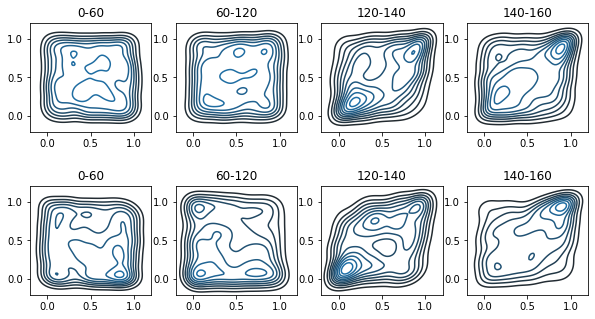

In [15]:
import seaborn as sns

with gpytorch.settings.num_likelihood_samples(1):
     Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(10,5))
fig.subplots_adjust(hspace=0.5)

X_pos = X.squeeze()*160
Y_pos = Y_sim.squeeze()

mrg = 0.2

for s,e,ax,name in zip([0,60,120,140],[60,120,140,160],axes.flatten(),['0-60','60-120','120-140','140-160']): #['0-1','1-2','2-3','3-4']
    sns.kdeplot(*Y_pos[(X_pos[:]>=s) & (X_pos[:]<e)].T, ax=ax, shade=False,  shade_lowest=True)
    ax.set(title=name, xlim=(-mrg,1+mrg), ylim=(-mrg,1+mrg))
    
X_pos = X.squeeze()*160
Y_pos = Y

mrg = 0.2

for s,e,ax,name in zip([0,60,120,140],[60,120,140,160],axes.flatten()[4:],['0-60','60-120','120-140','140-160']): #['0-1','1-2','2-3','3-4']
    sns.kdeplot(*Y_pos[(X_pos[:]>=s) & (X_pos[:]<e)].T, ax=ax, shade=False,  shade_lowest=True)
    ax.set(title=name, xlim=(-mrg,1+mrg), ylim=(-mrg,1+mrg))